* suppose you have an outcome you want to optimize
* let's consider the visit-to-signup conversion rate
* we are going to run split tests to optimize that lever
* for scale, we'll assume 100 conversions per day at a 5% conversion rate
 ** (2,000 views per day of the signup screen)
* each 'iteration' is another test run on the signup screen
 ** tests often focus on a single design or conversion element, as full page redesigns are very expensive

In [3]:
from random import random, uniform
import pandas as pd

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns

In [5]:
MAXITERS = 10
MAXOPTIONS = 20
MAXSIMS = 1000
LIFT = .1
NOISY = False

# chaos mode: if a variation wins, roll the die again to get a random lift [0,100%]
CHAOS_MODE = True
CHAOS_PROBABILITY = 0.1 #likelihood of activating chaos mode
CHAOS_MAX_LIFT = 1
CHAOS_DR = False # apply diminishing returns to chaos mode

# each non-control test winner produces diminshing returns
DIMINSHING_RETURNS_FACTOR = 0.9

In [6]:
def get_chaos_lift():
    roll = uniform( 0, CHAOS_MAX_LIFT )
    
    nprint( '--- CHAOS LIFT: {0}'.format( roll ) )
    
    return roll

def activate_chaos_mode():
    roll = random()
    
    return roll < CHAOS_PROBABILITY

def get_probabilities( numoptions=1, default_probs=[.9, .1] ):
    if numoptions<1:
        raise Exception( 'TooFewOptions' )

    data = default_probs
    
    rate = .1
    for i in range( 0, numoptions-1 ):
        rate = rate / 1.5
        data.append( rate )

    datasum = sum(data)
    normalized_data = [_/datasum for _ in data]
    
    nprint( 'numoptions: {0}, probs: {1}'.format( numoptions, normalized_data ) )

    return normalized_data
    
def pick_winner( probs ):
    # rolls die, picks the winner based on the weighted probabilities
    # returns the index of the winning probability
    r = random()
    nprint( 'picking a winner, probabilities: {0}, roll={1}'.format( probs, r ) )
    idx = 0
    for maxval in probs:
        if r <= maxval:
            return idx
        idx += 1
        
    return idx-1

def nprint( s ):
    # remove to un-overload
    if NOISY:
        print( s )

In [7]:
def run_test( max_options, num_tests, dimret=True, default_probs=[.9, .1] ):
    finalresults = {}
    for numoptions in range( 1, max_options+1):
        control_idx = 0
        probs = get_probabilities( numoptions, default_probs )
        print('number of options: {0}'.format(numoptions))

        simresults = []
        for simnum in range( 1, MAXSIMS+1 ):
            cr = 1
            # run the simulation
            for iternum in range(1, num_tests+1):
                winning_idx = pick_winner( probs )
                if winning_idx != control_idx: # a variation won!
                    if activate_chaos_mode():
                        nprint( 'CHAOS!!!' )
                        lift = get_chaos_lift()

                        if dimret and CHAOS_DR:
                            lift = lift * DIMINSHING_RETURNS_FACTOR**iternum

                        cr *= (1+lift)
                    else:
                        nprint( 'No Chaos :(')
                        if dimret:
                            drfactor = DIMINSHING_RETURNS_FACTOR**iternum
                        else:
                            drfactor = 1
                        cr *= ( 1+LIFT*drfactor )

                nprint( 'iteration: {0}, winner: {1}, cr: {2}\n'.format( iternum, winning_idx, cr ))

            # save the final conversion rate
            simresults.append( cr )

        finalresults[numoptions] = simresults
        
    df = pd.DataFrame(finalresults)
    
    return df

In [14]:
def plot_series( data ):
    tick_spacing=4
    sns.set()
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(12)
    fig.set_figheight(6)
    plt.xlabel('Number of variations per test')
    plt.ylabel('conversion rate lift (mean across {0} simulated runs)'.format( MAXSIMS ) )
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    for numtests, df in data.items():
        ax.plot([1]+list(df.mean()), label='{0} tests'.format( numtests ))
    plt.legend()
    plt.title('Winner Probability Profile: Nostradamus')
    plt.show()

## Scenario 1 - Nostradamus
In this scenario, we're examining a highly optimized element, such that we feel 90% confident our current implementation is the absolute best it could be (i.e. this screen has no room for improvement, as measured by the conversion rate.))

* 90% likelihood we are currently at the theoretically maximum conversion rate
* very unlikely scenario, but the puts an upper bound on the simulation
* first variation has a 10% chance of winning, all others have a 5%
 - 2 variations, probability of a winner is 90/10 (control/varB)
 - 3 variations: 85%/10%/5%
 - 4 variations: 80%/10%/5%/5%
* if a variation wins, winner provides a 10% lift.  else, control stays at the same rate
* an 'iteration' is a test number

In [9]:
data = {}
max_options = 20
for nt in [5, 10, 20]:
    print('running simulation for {0} tests'.format(nt) )
    data[nt] = run_test( max_options, nt, dimret=True )

running simulation for 5 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 10 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 20 tests
number of options: 1
number of options: 2
n

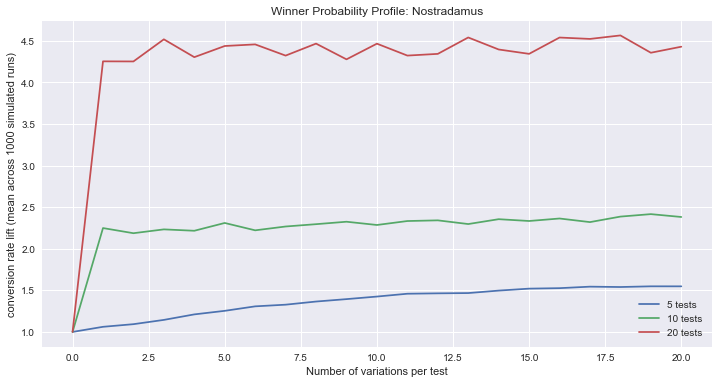

In [15]:
plot_series( data )

# Situation 2: Winner Probability Profile: Genius
* [0.67, 0.33] as the seed probability list for control, variation A, etc. probabilities
* gets decisions correct 2 out of 3 times when choosing between 2 options
* unlikely scenario, this profile is for people who have problem a 1 in a million ability to predict winners
* variation probabilities
 - 2 variations, probability of a winner is 67/33 (control/varB)
 - 3 variations: 67/33/22/14.6 -> non-normalized ratios
 - N variations: 67/33/22/14.6/ then (n-1)/1.5 for 3..N
* if a variation wins, winner provides a 10% lift.  else, control stays at the same rate
* an 'iteration' is a test number
* even just a simple a/b test has great returns in this uncertainty scenario, need fewer variations if you're going to run more tests (and vice versa)

running simulation for 5 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 10 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 20 tests
number of options: 1
number of options: 2
n

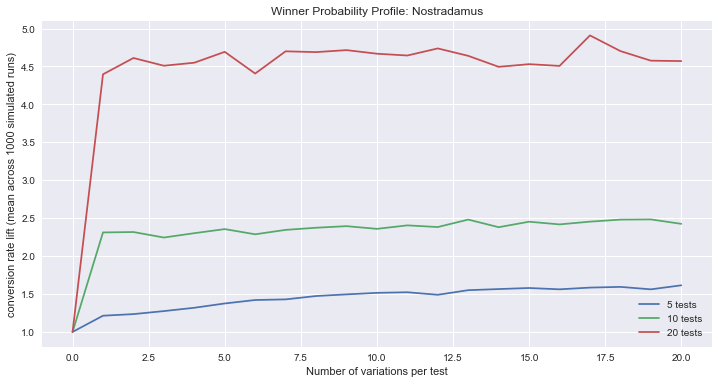

In [16]:
data = {}
max_options = 20
default_probs = [.67, .33]
for nt in [5, 10, 20]:
    print('running simulation for {0} tests'.format(nt) )
    data[nt] = run_test( max_options, nt, dimret=True, default_probs=default_probs )

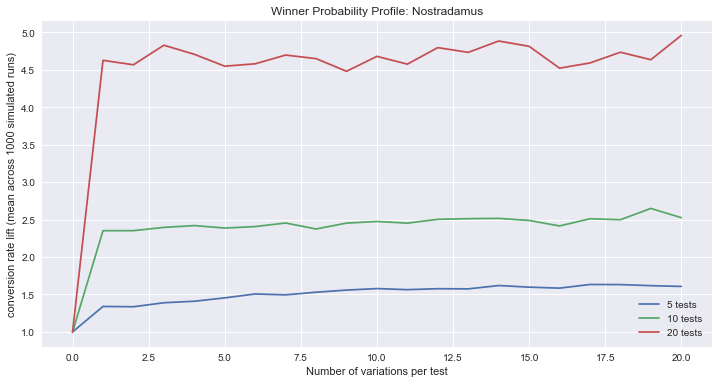

In [19]:
plot_series( data )

# Situation 3: Mostly random (lots of uncertainty)
* [0.5, 0.5] as the seed probability list for control, variation A, etc. probabilities
* gets decisions correct 1 out of 2 times when choosing between 2 options
* if a variation wins, winner provides a 10% lift.  else, control stays at the same rate

In [17]:
data = {}
max_options = 20
default_probs = [.5, .5]
for nt in [5, 10, 20]:
    print('running simulation for {0} tests'.format(nt) )
    data[nt] = run_test( max_options, nt, dimret=True, default_probs=default_probs )

running simulation for 5 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 10 tests
number of options: 1
number of options: 2
number of options: 3
number of options: 4
number of options: 5
number of options: 6
number of options: 7
number of options: 8
number of options: 9
number of options: 10
number of options: 11
number of options: 12
number of options: 13
number of options: 14
number of options: 15
number of options: 16
number of options: 17
number of options: 18
number of options: 19
number of options: 20
running simulation for 20 tests
number of options: 1
number of options: 2
n

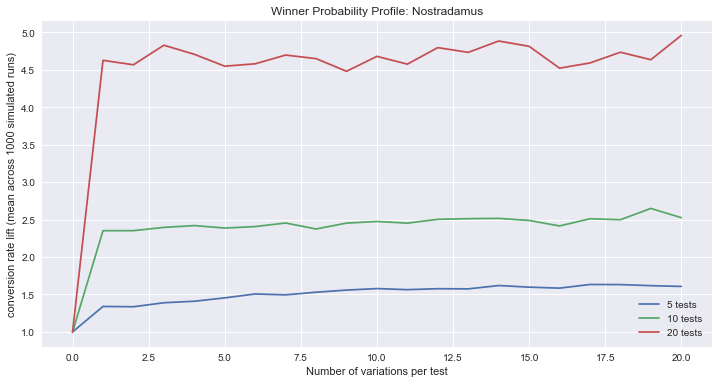

In [18]:
plot_series( data )